In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer


In [2]:
df = pd.DataFrame(pd.read_csv('gender_tweets.csv'))[['gender', 'text', 'description']]

df.dropna(inplace=True, ignore_index=True)
df = df[df['gender'] != 'unknown'].reset_index(drop=True)
df

,gender,text,description
0,male,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.
1,male,It felt like they were my friends and I was li...,I'm the author of novels filled with family dr...
2,male,i absolutely adore when louis starts the songs...,louis whining and squealing and all
3,male,Hi @JordanSpieth - Looking at the url - do you...,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe..."
4,female,Watching Neighbours on Sky+ catching up with t...,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...
...,...,...,...
15502,female,"@lookupondeath ...Fine, and I'll drink tea too...",(rp)
15503,male,Greg Hardy you a good player and all but don't...,"Whatever you like, it's not a problem at all. ..."
15504,male,You can miss people and still never want to se...,#TeamBarcelona ..You look lost so you should f...
15505,female,@bitemyapp i had noticed your tendency to pee ...,Anti-statist; I homeschool my kids. Aspiring t...


In [3]:
import re, string
import inflect

from nltk.corpus import stopwords

# Initialize inflect engine
p = inflect.engine()

# Function to convert ordinal string to words
def ordinal_to_words(ordinal_str):
    match = re.match(r"(\d+)(st|nd|rd|th)", ordinal_str)
    number = int(match.group(1))
    # Convert number to ordinal words
    return p.number_to_words(p.ordinal(number))


stopw = set(stopwords.words("english"))
stopw.update({"one", "time", "love", "u"})

def preprocess(transformer: str) -> str:
    transformer = transformer.lower()

    transformer = re.sub(r"https*\S+", " ", transformer)
    transformer = re.sub(r"^([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-]+)(\.[a-zA-Z]{2,5}){1,2}$", " ", transformer)
    transformer = re.sub(r"@\S+", " ", transformer)
    transformer = re.sub(r"#\S+", " ", transformer)
    if re.match(r"(\d+)(st|nd|rd|th)", transformer):
        transformer = re.sub(r"(\d+)(st|nd|rd|th)", ordinal_to_words(transformer), transformer)
    transformer = re.sub(r"&amp;", " ", transformer)
    transformer = re.sub(r"&gt;", " ", transformer)
    transformer = re.sub(r"&lt;", " ", transformer)
    transformer = re.sub(r"-", " ", transformer)
    transformer = re.sub(r"\d", " ", transformer)
    transformer = re.sub(r"�۪", " ", transformer)
    transformer = re.sub(r"[٪ή]", " ", transformer)
    transformer = re.sub(r"ٍ", " ", transformer)
    transformer = re.sub(r"[�۝ُԍϭջωԏե]", " ", transformer)
    transformer = re.sub("[%s]" % re.escape(string.punctuation), " ", transformer)
    transformer = re.sub(r"\s{2,}", " ", transformer)
    transformer = ' '.join([word for word in transformer.split(' ') if word not in stopw])
    return transformer.strip()

df_copy = df.copy()

df_copy['text'] = df_copy['text'].apply(preprocess)
df_copy['description'] = df_copy['description'].apply(preprocess)

df

,gender,text,description
0,male,Robbie E Responds To Critics After Win Against...,i sing my own rhythm.
1,male,It felt like they were my friends and I was li...,I'm the author of novels filled with family dr...
2,male,i absolutely adore when louis starts the songs...,louis whining and squealing and all
3,male,Hi @JordanSpieth - Looking at the url - do you...,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe..."
4,female,Watching Neighbours on Sky+ catching up with t...,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...
...,...,...,...
15502,female,"@lookupondeath ...Fine, and I'll drink tea too...",(rp)
15503,male,Greg Hardy you a good player and all but don't...,"Whatever you like, it's not a problem at all. ..."
15504,male,You can miss people and still never want to se...,#TeamBarcelona ..You look lost so you should f...
15505,female,@bitemyapp i had noticed your tendency to pee ...,Anti-statist; I homeschool my kids. Aspiring t...


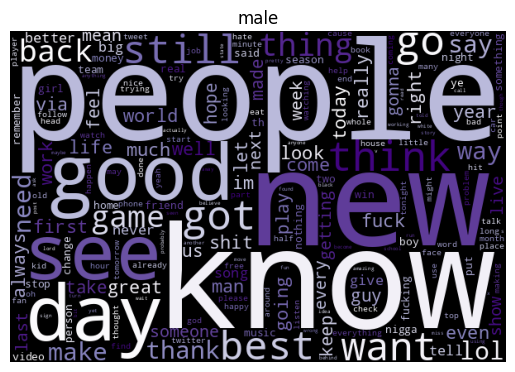

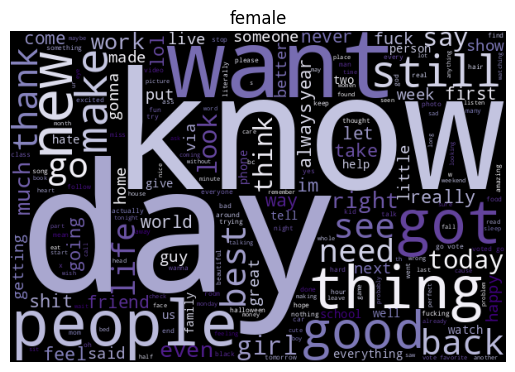

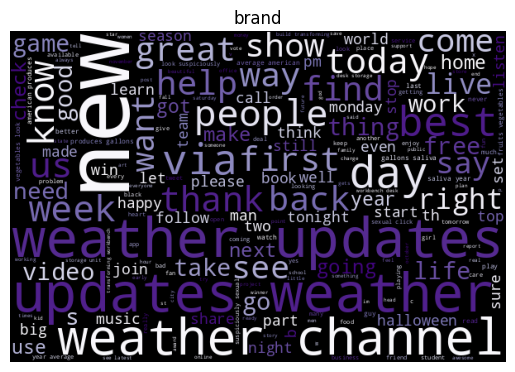

In [4]:
from wordcloud import WordCloud

for i in df_copy['gender'].unique():
    text = ''
    for tw in df_copy[df_copy['gender'] == i]['text']:
        text += tw + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="black", colormap='Purples_r').generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(i)
    plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

df_vectors = df_copy.copy()
df_vectors['gender'] = LabelEncoder().fit_transform(df['gender'])

X = df_vectors[['text', 'description']]
y = df_vectors['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_transformer = ColumnTransformer(
    transformers=[
        ('text_tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2)), 'text'),
        ('description_tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2)), 'description')
    ]
)

In [6]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', tfidf_transformer),
    ('svc', SVC(kernel='rbf'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.61      0.68       848
           1       0.56      0.65      0.60      1167
           2       0.53      0.53      0.53      1087

    accuracy                           0.60      3102
   macro avg       0.62      0.59      0.60      3102
weighted avg       0.61      0.60      0.60      3102

